## Dataset Explanation

The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, etc. The class labels and their standard associated integer values are listed below.

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck

170500096/170498071 [==============================] - 2s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


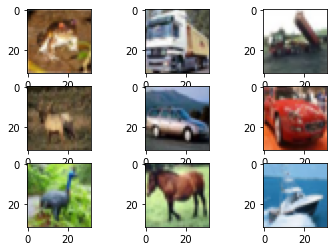

In [3]:
from matplotlib import pyplot
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

We can see that there are 50,000 examples in the training dataset and 10,000 in the test dataset and that images are indeed square with 32×32 pixels and color, with three channels.

## Test Harness

In order to best conduct an exploration of the various CNN modifications of this algorithm. I will first design a modular test harness, so that there is a seperate function for each piece. This allows a given aspect of the test harness to be modified or interchanged, if I desire, separately from the rest.

The test harness has five key elements
1. Loading Dataset: Loading dataset and storing it in X_train, X_test, y_train, y_test variables. One hot encoding of targets (y_train, y_test)
2. Dataset Preparation: Min-max scaling of inputs (X_train, X_test)
3. Model Definition: Choosing a certain CNN implementation
4. Model Evaluation: Fitting and evaluating model. Calculating model accuracy on y_test.
5. Result Presentation: Plotting graphs of model accuracy and cross entropy loss for each epoch. 

### 1. Loading Dataset

Here we are essentially loading the dataset and then one-hot encoding the targets. 

In [4]:
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras import regularizers
import sys

# load dataset
(trainX, trainY), (testX, testY) = cifar10.load_data()

# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY


### 2. Preparing Data

Here we first convert the train inputs from integers to floats. Then we scale the pixels using min-max normalization. 

In [5]:
# convert from integers to floats
train_norm = trainX.astype('float32')
test_norm = testX.astype('float32')
# normalize to range 0-1
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0

In [6]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

### 3. Defining Model

In this section of the test harness we are going to define some CNN model. 

In [7]:
# define cnn model
def define_model():
    model = Sequential()
    # ...
    return model

### 4. Evaluating Model

After the model is defined, we need to fit and evaluate it. Fitting the model will require that the number of training epochs and batch size to be specified. We will use a generic 100 training epochs for now and a modest batch size of 64. The test dataset will be used as a validation dataset and evaluated at the end of each training epoch. This will result in a trace of model evaluation scores on the train and test dataset each epoch that can be plotted later. This is just the pseudocode for this part. I have commented it out as we haven't defined a model yet.

In [8]:
# fit model
#history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=0)

Once the model is fit, we will use to evaluate on the test dataset

In [9]:
# evaluate model
#_, acc = model.evaluate(testX, testY, verbose=0)

### 5. Presenting Results

There are two key aspects to present: the diagnostics of the learning behavior of the model during training and the estimation of the model performance.

This section will create a line plot showing model performance on the train and test set during training. These plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset.

We will create a single figure with two subplots, one for loss and one for accuracy. The blue lines will indicate model performance on the training dataset and orange lines will indicate performance on the hold out test dataset.

In [10]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    
    pyplot.close()

The summarize_diagnostics() function acove creates and shows this plot. The plot is saved to file, with the file name name as the script with a ‘png‘ extension.

In [11]:
#print('> %.3f' % (acc * 100.0))

This will print out the classification accuracy achieved on the test dataset.

## Test Harness Function

Here is the code for running this test harness

In [12]:
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=1)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=1)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    return history

## Model 1: Baseline Model

We can now investigate a baseline model for the CIFAR-10 dataset. A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement. For the baseline model I will be using a 3 block VGG. 

We can generalize the specification of a VGG-block as one or more convolutional layers with the same number of filters and a filter size of 3×3, a stride of 1×1, same padding so the output size is the same as the input size for each filter, and the use of a ReLU activation function. These layers are then followed by a max pooling layer with a size of 2×2 and a stride of the same dimensions.

Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128 for the first three blocks of the model. Padding is used on the convolutional layers to ensure the height and width of the output feature maps matches the inputs.

For my project, I have decided to define a baseline model to be a CNN with 3 VGG blocks. Here is the code used in the define_model() function to implement the baseline model:

In [13]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
history = run_test_harness()


Epoch 1/100
782/782 [==============================] - 46s 21ms/step - loss: 1.9656 - accuracy: 0.2833 - val_loss: 1.5214 - val_accuracy: 0.4339
Epoch 2/100
782/782 [==============================] - 15s 19ms/step - loss: 1.4295 - accuracy: 0.4892 - val_loss: 1.2827 - val_accuracy: 0.5393
Epoch 3/100
782/782 [==============================] - 15s 19ms/step - loss: 1.2384 - accuracy: 0.5600 - val_loss: 1.2043 - val_accuracy: 0.5736
Epoch 4/100
782/782 [==============================] - 15s 19ms/step - loss: 1.0948 - accuracy: 0.6166 - val_loss: 1.0624 - val_accuracy: 0.6292
Epoch 5/100
782/782 [==============================] - 15s 19ms/step - loss: 0.9923 - accuracy: 0.6496 - val_loss: 0.9920 - val_accuracy: 0.6542
Epoch 6/100
782/782 [==============================] - 15s 20ms/step - loss: 0.9030 - accuracy: 0.6813 - val_loss: 0.9601 - val_accuracy: 0.6664
Epoch 7/100
782/782 [==============================] - 15s 19ms/step - loss: 0.8259 - accuracy: 0.7132 - val_loss: 0.9026 - val_ac

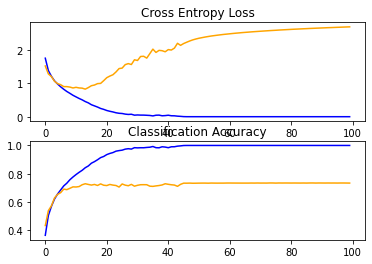

In [ ]:
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

## Model 2: Dropout Regularization

Dropout is a simple technique that will randomly drop nodes out of the network. It has a regularizing effect as the remaining nodes must adapt to pick-up the slack of the removed nodes. I used a dropout rate of 20%

In [ ]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
history = run_test_harness()

Epoch 1/100
782/782 [==============================] - 17s 21ms/step - loss: 2.1945 - accuracy: 0.1932 - val_loss: 1.6931 - val_accuracy: 0.4027
Epoch 2/100
782/782 [==============================] - 16s 20ms/step - loss: 1.7389 - accuracy: 0.3580 - val_loss: 1.5300 - val_accuracy: 0.4466
Epoch 3/100
782/782 [==============================] - 16s 20ms/step - loss: 1.5344 - accuracy: 0.4361 - val_loss: 1.3686 - val_accuracy: 0.5139
Epoch 4/100
782/782 [==============================] - 16s 20ms/step - loss: 1.4275 - accuracy: 0.4756 - val_loss: 1.3044 - val_accuracy: 0.5347
Epoch 5/100
782/782 [==============================] - 16s 20ms/step - loss: 1.3568 - accuracy: 0.5084 - val_loss: 1.2419 - val_accuracy: 0.5541
Epoch 6/100
782/782 [==============================] - 16s 20ms/step - loss: 1.2818 - accuracy: 0.5364 - val_loss: 1.1525 - val_accuracy: 0.5911
Epoch 7/100
782/782 [==============================] - 16s 20ms/step - loss: 1.2067 - accuracy: 0.5659 - val_loss: 1.1474 - val_ac

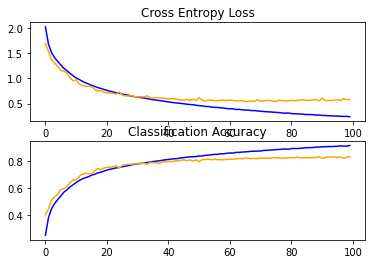

In [ ]:
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

## Model 3: Weight Decay

Weight regularization or weight decay involves updating the loss function to penalize the model in proportion to the size of the model weights. This has a regularizing effect, as larger weights result in a more complex and less stable model, whereas smaller weights are often more stable and more general. We can add weight regularization to the convolutional layers and the fully connected layers by defining the “kernel_regularizer” argument and specifying the type of regularization. In this case, we will use L2 weight regularization, with a weighting of 0.001.

In [ ]:

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
history=run_test_harness()

Epoch 1/100
782/782 [==============================] - 17s 21ms/step - loss: 3.1340 - accuracy: 0.2760 - val_loss: 2.6999 - val_accuracy: 0.4241
Epoch 2/100
782/782 [==============================] - 16s 20ms/step - loss: 2.5604 - accuracy: 0.4794 - val_loss: 2.3781 - val_accuracy: 0.5370
Epoch 3/100
782/782 [==============================] - 16s 20ms/step - loss: 2.3359 - accuracy: 0.5541 - val_loss: 2.2698 - val_accuracy: 0.5699
Epoch 4/100
782/782 [==============================] - 16s 20ms/step - loss: 2.1759 - accuracy: 0.6066 - val_loss: 2.1251 - val_accuracy: 0.6132
Epoch 5/100
782/782 [==============================] - 16s 20ms/step - loss: 2.0434 - accuracy: 0.6493 - val_loss: 2.0441 - val_accuracy: 0.6390
Epoch 6/100
782/782 [==============================] - 16s 20ms/step - loss: 1.9304 - accuracy: 0.6819 - val_loss: 1.9685 - val_accuracy: 0.6643
Epoch 7/100
782/782 [==============================] - 16s 20ms/step - loss: 1.8332 - accuracy: 0.7068 - val_loss: 1.9130 - val_ac

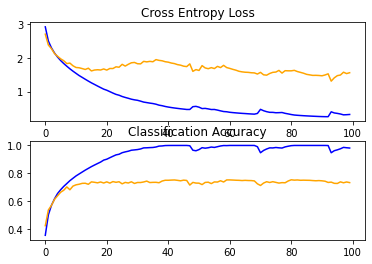

In [ ]:
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

## Model 4: Data Augmentation

Data augmentation involves making copies of the examples in the training dataset with small random modifications. This has a regularizing effect as it both expands the training dataset and allows the model to learn the same general features, although in a more generalized manner. There are many types of data augmentation that could be applied. Given that the dataset is comprised of small photos of objects, we do not want to use augmentation that distorts the images too much, so that useful features in the images can be preserved and used.

The types of random augmentations that could be useful include a horizontal flip, minor shifts of the image, and small zooming or cropping of the image.

I used horizontal flips and 10% shifts in the height and width of the image.

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(trainX, trainY, batch_size=64)

def run_test_harness():
# load dataset
  trainX, trainY, testX, testY = load_dataset()
  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(trainX, trainY, batch_size=64)
  # fit model
  steps = int(trainX.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=100, validation_data=(testX, testY), verbose=1)

# evaluate model
  _, acc = model.evaluate(testX, testY, verbose=0)
  print('> %.3f' % (acc * 100.0))
# learning curves
  summarize_diagnostics(history)
  return history

In [21]:
history = run_test_harness()

Epoch 1/100
781/781 [==============================] - 26s 32ms/step - loss: 1.9602 - accuracy: 0.2872 - val_loss: 1.5014 - val_accuracy: 0.4619
Epoch 2/100
781/781 [==============================] - 25s 32ms/step - loss: 1.5417 - accuracy: 0.4393 - val_loss: 1.3860 - val_accuracy: 0.5043
Epoch 3/100
781/781 [==============================] - 25s 32ms/step - loss: 1.4130 - accuracy: 0.4952 - val_loss: 1.2774 - val_accuracy: 0.5478
Epoch 4/100
781/781 [==============================] - 26s 33ms/step - loss: 1.3034 - accuracy: 0.5369 - val_loss: 1.1763 - val_accuracy: 0.5827
Epoch 5/100
781/781 [==============================] - 26s 34ms/step - loss: 1.2319 - accuracy: 0.5607 - val_loss: 1.1054 - val_accuracy: 0.6089
Epoch 6/100
781/781 [==============================] - 27s 34ms/step - loss: 1.1566 - accuracy: 0.5898 - val_loss: 1.0493 - val_accuracy: 0.6342
Epoch 7/100
781/781 [==============================] - 26s 33ms/step - loss: 1.0997 - accuracy: 0.6148 - val_loss: 1.0223 - val_ac

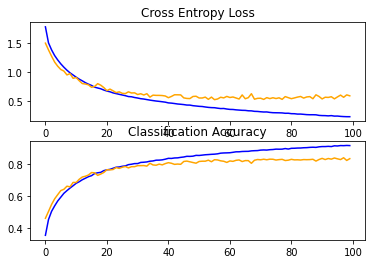

In [22]:
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')